In [2]:
import pandas as pd
import pyextremes 
from matplotlib import pyplot as plt

df=pd.read_csv("dataset\MLTempDataset.csv")
df.head(20)
df_new = df[['DAYTON_MW','Datetime']].copy()
df_new.head(10)
data=df_new.sort_index(ascending=True).dropna()
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)
data.columns


Index(['DAYTON_MW'], dtype='object')

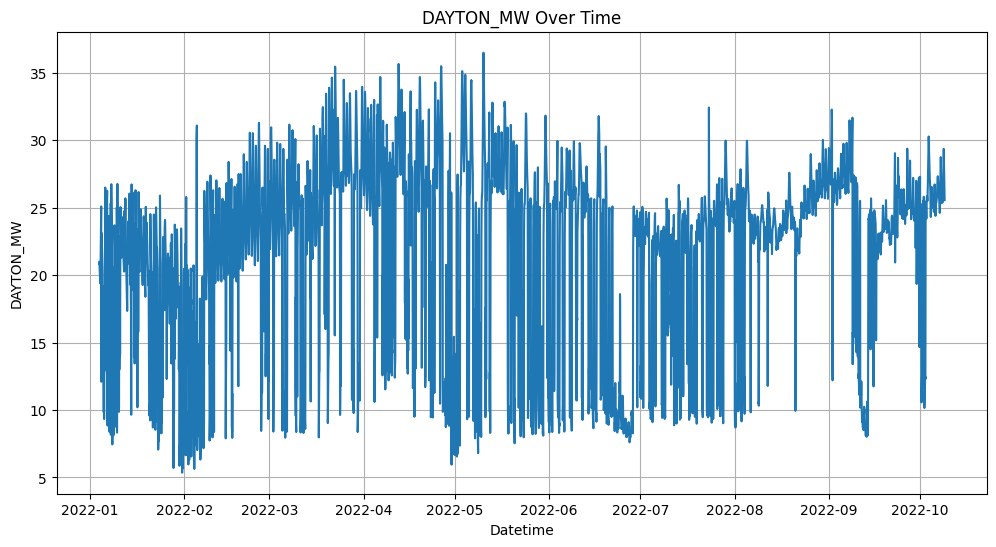

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(data['DAYTON_MW'])
plt.title('DAYTON_MW Over Time')
plt.xlabel('Datetime')
plt.ylabel('DAYTON_MW')
plt.grid(True)
plt.show()

# POT Isolation

In [4]:
threshold=data['DAYTON_MW'].quantile(0.2)
# threshold=12

extremes = data[data['DAYTON_MW'] < threshold]
len(extremes)


1334

# Block Max


In [5]:
# # Set your block size (e.g., '30D' for 30-day blocks)
# block_size = '12H'  

# # Calculate block groups
# block_groups = (data.index - data.index[0]) // pd.Timedelta(block_size)

# # Find maxima indices and filter the DataFrame
# max_indices = data.groupby(block_groups)['DAYTON_MW'].idxmax()
# extremes = data.loc[max_indices]
# len(extremes)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


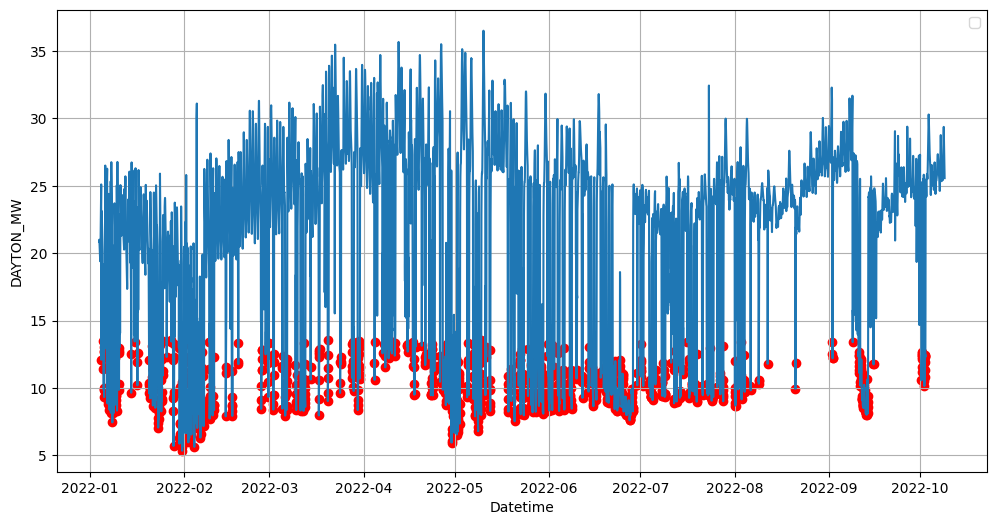

In [6]:
plt.figure(figsize=(12, 6))
plt.xlabel('Datetime')
plt.ylabel('DAYTON_MW')
plt.legend()
plt.grid(True)
plt.plot(data['DAYTON_MW'])
plt.scatter(extremes.index, extremes['DAYTON_MW'], color='red', label='Exceedances')
plt.show()

In [7]:
print (extremes['DAYTON_MW'].median())

9.933


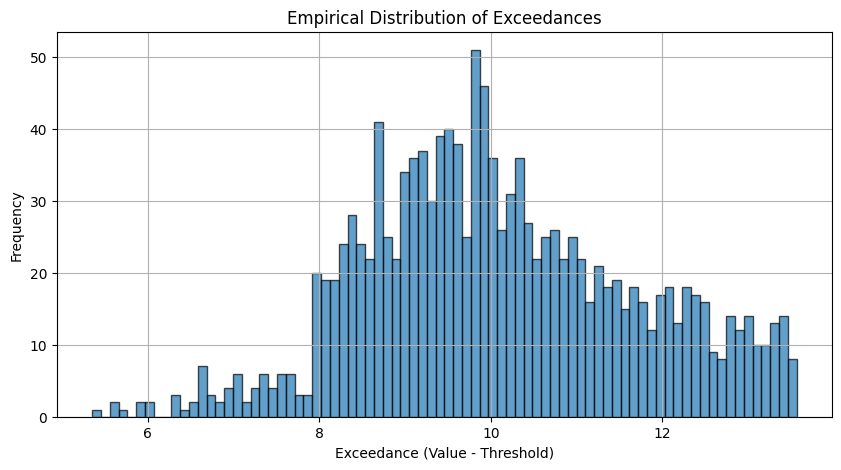

In [31]:
bin_Size=80
plt.figure(figsize=(10, 5))
plt.hist(extremes, bins=bin_Size, edgecolor='black', alpha=0.7)
plt.title('Empirical Distribution of Exceedances')
plt.xlabel('Exceedance (Value - Threshold)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [32]:
from scipy.stats import genpareto
shape, loc, scale = genpareto.fit(extremes)
print(f"Shape (ξ): {shape:.4f}")
print(f"Scale (β): {scale:.4f}")



Shape (ξ): -1.5728
Scale (β): 21.3298


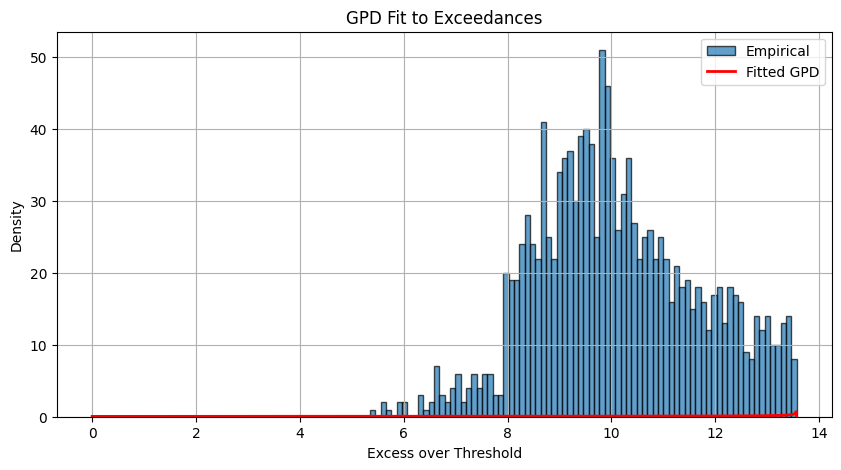

In [42]:
import numpy as np
x = np.linspace(0, extremes.max(), 1000)
pdf = genpareto.pdf(x, c=shape, loc=0, scale=scale)
shape, loc, scale = genpareto.fit(extremes)

plt.figure(figsize=(10, 5))
plt.hist(extremes, bins=bin_Size, edgecolor='black', alpha=0.7, label='Empirical')
plt.plot(x, pdf, 'r-', lw=2, label='Fitted GPD')
plt.title('GPD Fit to Exceedances')
plt.xlabel('Excess over Threshold')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

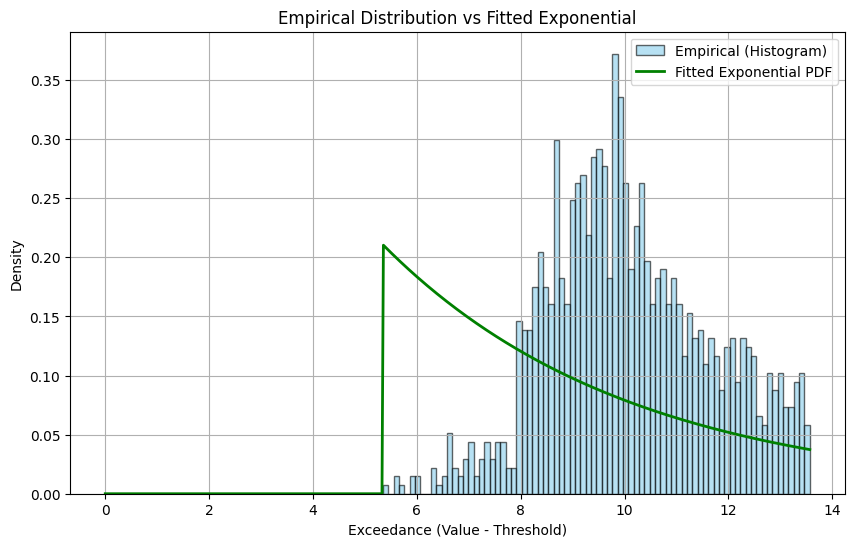

In [44]:
from scipy.stats import expon

# Fit Exponential distribution to the exceedances
loc, scale = expon.fit(extremes)

# Generate PDF values
x = np.linspace(0, extremes.max(), 500)
pdf_exp = expon.pdf(x, loc=loc, scale=scale)

# Plot histogram + fitted PDF
plt.figure(figsize=(10, 6))
plt.hist(extremes, bins=bin_Size, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Empirical (Histogram)')
plt.plot(x, pdf_exp, 'g-', lw=2, label='Fitted Exponential PDF')
plt.title('Empirical Distribution vs Fitted Exponential')
plt.xlabel('Exceedance (Value - Threshold)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

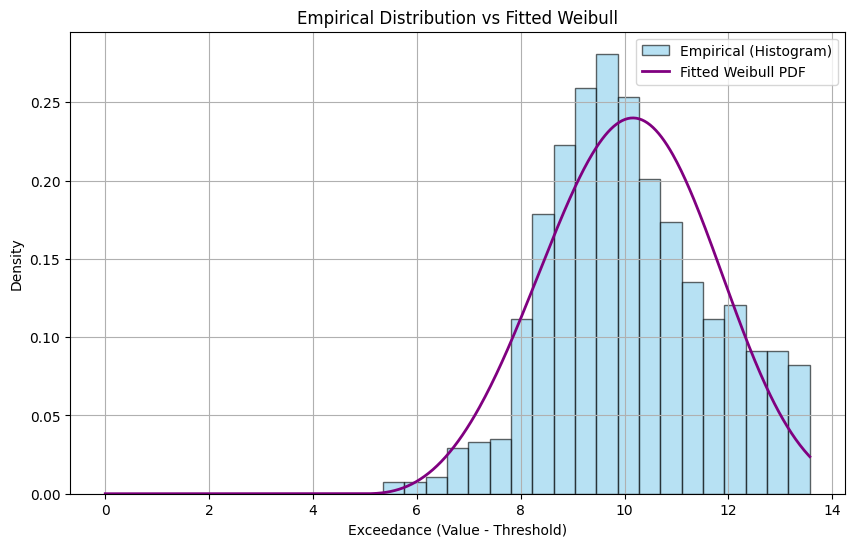

In [46]:
from scipy.stats import weibull_min

# Fit Weibull distribution
shape, loc, scale = weibull_min.fit(extremes)

# Generate PDF
pdf_weib = weibull_min.pdf(x,shape, loc=loc, scale=scale)

# Plot
plt.figure(figsize=(10, 6))
plt.hist(extremes, bins=20, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Empirical (Histogram)')
plt.plot(x, pdf_weib, 'purple', lw=2, label='Fitted Weibull PDF')
plt.title('Empirical Distribution vs Fitted Weibull')
plt.xlabel('Exceedance (Value - Threshold)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

0.26707550313747264 9.53382575579049 1.5490691044092912


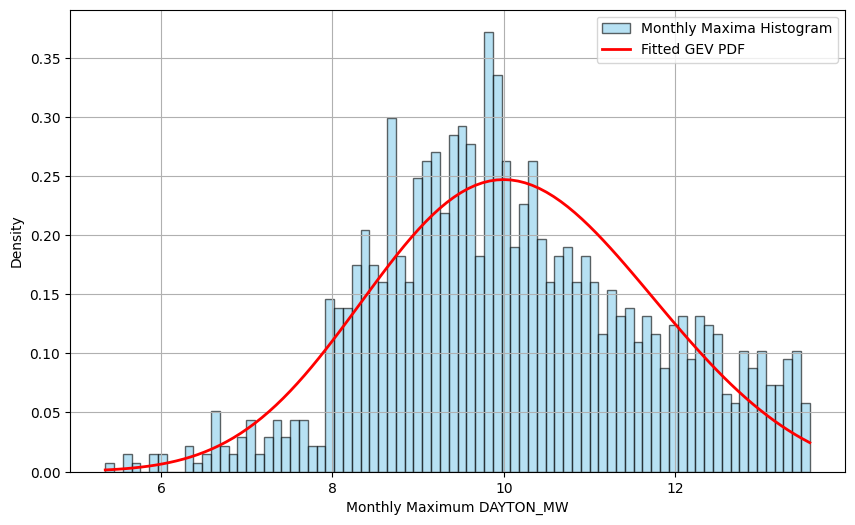

In [36]:
from scipy.stats import genextreme

# Fit GEV: note that scipy uses a different sign convention for shape parameter
shape, loc, scale = genextreme.fit(extremes)
print (shape, loc, scale)
import numpy as np
import matplotlib.pyplot as plt

# Generate x and PDF
x = np.linspace(extremes.min(),extremes.max(), 100)
gev_pdf = genextreme.pdf(x, c=shape, loc=loc, scale=scale)

# Plot histogram and GEV PDF
plt.figure(figsize=(10, 6))
plt.hist(extremes, bins=bin_Size, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Monthly Maxima Histogram')
plt.plot(x, gev_pdf, 'r-', lw=2, label='Fitted GEV PDF')
plt.xlabel('Monthly Maximum DAYTON_MW')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


#R2

In [37]:

y_obser, bin_edges = np.histogram(extremes, bins=bin_Size, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
y_mean = np.mean(y_obser)
ss_tot = np.sum((y_obser - y_mean) ** 2)

shape_gev, loc_gev, scale_gev = genextreme.fit(extremes)
gev_pdf = genextreme.pdf(bin_centers, c=shape_gev, loc=loc_gev, scale=scale_gev)
ss_res_gev = np.sum((y_obser - gev_pdf) ** 2)
r2_gev = 1 - (ss_res_gev / ss_tot)

shape_wei, loc_wei, scale_wei = weibull_min.fit(extremes)
wei_pdf = weibull_min.pdf(bin_centers, c=shape_wei, loc=loc_wei, scale=scale_wei)
ss_res_wei = np.sum((y_obser - wei_pdf) ** 2)
r2_wei = 1 - (ss_res_wei / ss_tot)

loc_exp, scale_exp = expon.fit(extremes)
expon_pdf = expon.pdf(bin_centers, loc=loc_exp, scale=scale_exp)
ss_res_exp = np.sum((y_obser - expon_pdf) ** 2)
r2_exp = 1 - (ss_res_exp / ss_tot)

print(f"R² (GEV):     {r2_gev:.4f}")
print(f"R² (Weibull): {r2_wei:.4f}")
print(f"R² (Expon):   {r2_exp:.4f}")



R² (GEV):     0.7920
R² (Weibull): 0.7572
R² (Expon):   -0.8686


# P_Value_TEST

1334
80


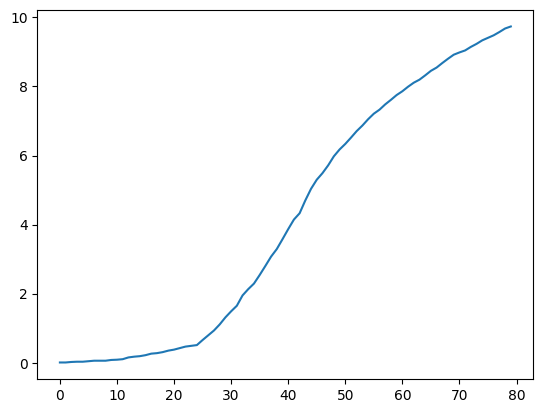

In [38]:
df = data.copy().reset_index(drop=True)  # Drops the old index, replaces with 0,1,2,...
# print(df)
threshold=data['DAYTON_MW'].quantile(0.2)
extremes = data[data['DAYTON_MW'] < threshold]
print(len(extremes))
y_obser, bin_edges = np.histogram(extremes, bins=bin_Size, density=True)
# print(y_obser)

ecdf_obs=[]
n=0
for val in y_obser:
    ecdf_obs.append(val+n)
    n+=val
print (len(ecdf_obs))


plt.plot(ecdf_obs)



    


0.26707550313747264 9.53382575579049 1.5490691044092912
80


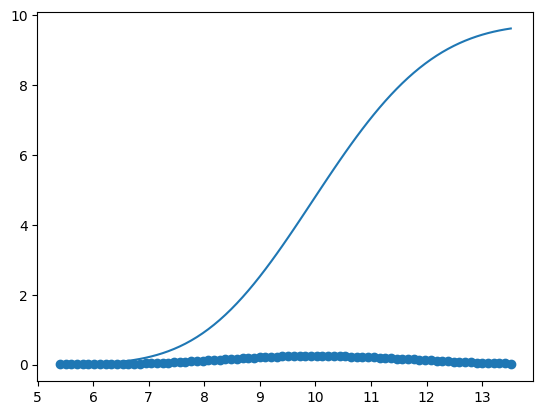

In [39]:
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

shape, loc, scale = genextreme.fit(extremes)
print (shape, loc, scale)
gev_pdf = genextreme.pdf(bin_centers, c=shape, loc=loc, scale=scale)

ecdf_pred=[]
n=0
for val in gev_pdf:
    ecdf_pred.append(val+n)
    n=val+n
print (len(ecdf_pred))
plt.plot(bin_centers,ecdf_pred)

plt.scatter(bin_centers,gev_pdf)

In [40]:
import math
itr=len(ecdf_pred)
i=0
D=[]
while i<itr:
    D.append(ecdf_pred[i]-ecdf_obs[i])
    i+=1

Dm=max(D)
print("Dm=",max(D))
Dc=1.36/math.sqrt(itr)
print ("Dc=",Dc)

P_Val=2*math.exp(-2*itr*Dm**2)
print("P_Val=",P_Val)

Dm= 0.29379501783074957
Dc= 0.15205262246998572
P_Val= 2.01008244406374e-06
